In [ ]:
#!pip install xgboost
#!pip install joblib
#!pip install imbalanced-learn
#!pip install dask_ml
#!pip install imblearn

## 737 csv DataFrame

In [1]:
import dask
import dask.dataframe as dd
import joblib
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


def perform_tasks_with_dask(file_pattern, num_workers=16, threads_per_worker=12, use_gpu=True):
    """
    Perform tasks using Dask, such as reading CSV files, configuring Dask, and printing the first 5 rows.

    :param file_pattern: A file pattern to match CSV files.
    :param num_workers: The number of Dask workers to use.
    :param threads_per_worker: The number of threads per Dask worker.
    :param use_gpu: Whether to use GPU for Dask computations.
    :return: A Dask DataFrame containing the data.
    """
    dask.config.set(scheduler='threads', num_workers=num_workers, threads_per_worker=threads_per_worker, use_gpu=use_gpu)

    df = dd.read_csv(file_pattern, assume_missing=True, header=0)
    df = df.reset_index()

    # Specify the columns you want to keep
    columns_to_keep = ['col5_float', 'col7_float', 'col13_float', 'col15_float', 'col23_float', 'col27_float', 'stableCruise_boolean'] 
    # Use square brackets to select and keep the specified columns
    df_subset = df[columns_to_keep]
    return df_subset
    # numero_de_filas_exacto = len(df)
    # print("Número de filas exacto:", numero_de_filas_exacto)
    
def balance_dataset(df, target_column, random_state=42):
    """
    Balance a Dask DataFrame to have equal class proportions for the target variable.

    Args:
        df (dask.dataframe.DataFrame): The DataFrame containing the data.
        target_column (str): The name of the target column to be balanced.
        random_state (int): Random seed for reproducibility.

    Returns:
        dask.dataframe.DataFrame: The balanced Dask DataFrame.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]

    rus = RandomUnderSampler(sampling_strategy='majority', random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X.compute(), y.compute())

    df_resampled = dd.from_pandas(pd.DataFrame(data=X_resampled, columns=X.columns), npartitions=1)
    df_resampled[target_column] = y_resampled

    return df_resampled

if __name__ == "__main__":
    #file_pattern = "../../Data/TMP_Data/*.csv"
    file_pattern = "../../Data/EC_Data/*.csv"
    df = perform_tasks_with_dask(file_pattern)
    df_balanced = balance_dataset(df, 'stableCruise_boolean')
    print(df_balanced.compute().head(10))



     col5_float  col7_float  col13_float  col15_float  col23_float  \
0   2954.401611  182.553223     0.290983    54.670597    13.929480   
1  11083.237305  241.951767     0.446844    94.126999     3.682296   
2  21999.474609  277.999725     0.629491    75.356895    -9.174471   
3    947.695557  183.598831     0.282296    96.549637    17.686922   
4  40999.910156  250.048431     0.840228    85.701920   -25.843906   
5    123.967957    4.050034     0.005726    22.194834    14.759303   
6  37988.152344  263.847961     0.828326    82.245430   -26.706100   
7  32974.277344  295.597748     0.827762    83.356934   -19.731300   
8  30859.298828  301.422607     0.807691    86.642220   -16.458363   
9  40942.085938  247.580673     0.831864    99.329300   -26.451054   

   col27_float  stableCruise_boolean  
0    60.764046                   0.0  
1     0.000008                   0.0  
2    49.277233                   0.0  
3     0.000008                   0.0  
4     3.671783                   0

In [2]:
# Define the independent variables (X) and the dependent variable (y)
X = df_balanced.compute()[['col5_float', 'col7_float', 'col13_float', 'col15_float', 'col23_float', 'col27_float']]
y = df_balanced.compute()['stableCruise_boolean']

## L2 Hiperparam 

In [ ]:
import dask
import dask.dataframe as dd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1]
}
 
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1],
                         'penalty': ['l2']})

In [7]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Mejores hiperparámetros: {best_params}")
print(f"Puntuación de precisión en el conjunto de prueba: {accuracy}")

Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l2'}
Puntuación de precisión en el conjunto de prueba: 0.7177335226775607


## VIF

In [19]:
#X2 = X.drop('col7_float', axis=1)
#X3 = X2.drop('col17_float', axis=1)
# Calculate VIF using variance_inflation_factor
#vif_data = pd.DataFrame()
#vif_data["Variable"] = X3.columns
#vif_data["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]

# Filter the VIF results for the features (exclude 'const')
#vif_results = vif_data[vif_data["Variable"] != 'const']

# Print the VIF results
#print(vif_results)

      Variable       VIF
0  col23_float  2.186432
1  col27_float  1.932445
2   col7_float  2.881075


## PCA

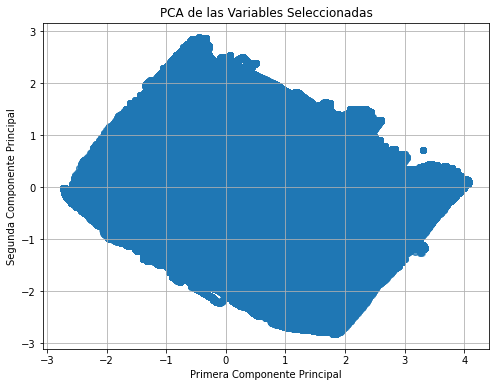

In [3]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
scaled_data = scaler.fit_transform(X) 
# Realiza el PCA
pca = PCA() 
pca_result = pca.fit_transform(scaled_data) 
# Gráfico de dispersión de las dos primeras componentes principales
plt.figure(figsize=(8, 6)) 
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5) 
plt.xlabel("Primera Componente Principal") 
plt.ylabel("Segunda Componente Principal") 
plt.title("PCA de las Variables Seleccionadas") 
plt.grid() 
plt.show()

## Data Scaling

In [3]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
X_scaled_data = scaler.fit_transform(X) 

## Winsorization for outliers

In [3]:
def winsorize_variable(data, variable, new_column_name, lower_percentile=0.01, upper_percentile=0.99):
    """
    Realiza la winsorización de una variable en un conjunto de datos y la almacena en una nueva columna.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        variable (str): El nombre de la variable que se va a winsorizar.
        new_column_name (str): El nombre para la nueva columna que almacenará los datos winsorizados (si no se proporciona, se usará el nombre de la variable original con "_winsorized").
        lower_percentile (float): Percentil inferior para la winsorización (valor predeterminado es 0.01).
        upper_percentile (float): Percentil superior para la winsorización (valor predeterminado es 0.99).
    """
    if new_column_name is None:
        new_column_name = variable + "_winsorized"

    lower_limit = data[variable].quantile(lower_percentile)
    upper_limit = data[variable].quantile(upper_percentile)

    data[new_column_name] = data[variable].clip(lower_limit, upper_limit)

In [4]:
winsorize_variable(X, "col7_float", "wzcol7_float")

In [8]:
X_scaled_data


array([[-1.4617446 , -2.079246  ,  0.09946134, -2.10039577,  1.3489583 ,
         1.34586595],
       [-1.3444048 , -2.079246  , -1.73518873, -1.6131454 ,  1.1443291 ,
         1.32147492],
       [-1.3444048 , -2.079246  , -1.73518873, -1.6131454 ,  1.1443291 ,
         1.32147492],
       ...,
       [-1.47620579, -2.05609925, -1.8153072 , -1.60124253,  1.37497104,
         1.32147492],
       [-1.4761975 , -2.05169584, -1.8130923 , -1.60124294,  1.37498067,
         1.32147492],
       [-1.4761975 , -2.05169584, -1.8130923 , -1.60124328,  1.37498067,
         1.32147492]])

In [5]:
X2 = X.drop('col7_float', axis=1)

In [6]:
# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X2, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## MODELO 1 (Logistic)

In [7]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the logistic regression model
model = LogisticRegression(penalty='l2', C=0.1)
#model = LogisticRegression()

# Create a pipeline with SMOTE for oversampling
#over_sampling = SMOTE(sampling_strategy=0.7)   # Adjust sampling_strategy as needed
#pipeline = Pipeline(steps=[('oversample', over_sampling), ('model', model)])

# Train the model on the training set using the pipeline
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [14]:
import joblib
model_filename = 'L2_Undersamplin_logistic_7var_model2.pkl'
joblib.dump(model, model_filename)

print("Model saved to ", model_filename)

Model saved to  L2_Undersamplin_logistic_7var_model2.pkl


In [ ]:
#import joblib
#model_filename = 'L2_logistic_7var_model.pkl'
#loaded_model1 = joblib.load(model_filename)

In [8]:
from sklearn.model_selection import cross_val_score

# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print the accuracy on the training set
print("Model accuracy on the training set:", accuracy_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print the accuracy on the test set
print("Model accuracy on the test set:", accuracy_test)

# Make predictions on the validation set (if available)
#y_pred_val = model.predict(X_val)

# Calculate the accuracy of the model on the validation set
#accuracy_val = accuracy_score(y_val, y_pred_val)

# Cross_val
Cross_val = abs(cross_val_score(LogisticRegression(), X_train, y_train, cv=5, scoring="accuracy").mean())

# Print the accuracy on the validation set
#print("\nModel accuracy on the validation set:", accuracy_val)
print("\nModel accuracy on the validation set:", Cross_val)

# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)
print('\nClassification Report for the test set:')
print(class_report)

Model accuracy on the training set: 0.7130932530635389
Model accuracy on the test set: 0.7121320213754021

Model accuracy on the validation set: 0.7125851195251967
Confusion Matrix for the test set:
[[23348 13489]
 [ 7897 29557]]

Classification Report for the test set:
              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69     36837
         1.0       0.69      0.79      0.73     37454

    accuracy                           0.71     74291
   macro avg       0.72      0.71      0.71     74291
weighted avg       0.72      0.71      0.71     74291



## Modelo 2 (XGBoost)

In [9]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Create an XGBoost classifier
model2 = xgb.XGBClassifier(reg_lambda=0.1)
#model2 = xgb.XGBClassifier()

# Create a pipeline with SMOTE for oversampling
#over_sampling = SMOTE(sampling_strategy=0.7)   # Adjust sampling_strategy as needed
#pipeline = Pipeline(steps=[('oversample', over_sampling), ('model2', model2)])

# Train the model on the training set using the pipeline
model2.fit(X_train, y_train)


c:\DSA-Apps\Anaconda3\v3_9_7_x64\Local\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
import joblib
model_filename = 'L2_Undersamplin_xgboost_7var_model2.pkl'
joblib.dump(model2, model_filename)

print("Model saved to ", model_filename)

Model saved to  L2_Undersamplin_xgboost_7var_model2.pkl


In [ ]:
#import joblib
#model_filename = 'xgboost_7var_model.pkl'
#pipeline = joblib.load(model_filename)

In [10]:
# Make predictions on the training set
y_pred_train = model2.predict(X_train)

# Calculate the training set accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print the training set accuracy
print("Training set accuracy:", accuracy_train)

# Make predictions on the test set
y_pred_test = model2.predict(X_test)

# Calculate the test set accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print the test set accuracy
print("Test set accuracy:", accuracy_test)

# Make predictions on the validation set (if available)
#y_pred_val = model2.predict(X_val)

# Calculate the validation set accuracy
#accuracy_val = accuracy_score(y_val, y_pred_val)

# Cross validation
params = {     
    'objective': 'binary:logistic',     
    'eval_metric': 'logloss'} 

cross_val = abs(cross_val_score(xgb.XGBClassifier(**params), X_train, y_train, cv=5, scoring="accuracy").mean())
# Print the validation set accuracy
#print("\nValidation set accuracy:", accuracy_val)
print("\nValidation set accuracy:", cross_val)


# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)
print('\nClassification Report for the test set:')
print(class_report)

Training set accuracy: 0.9442413208845606
Test set accuracy: 0.9420791212932926


c:\DSA-Apps\Anaconda3\v3_9_7_x64\Local\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\DSA-Apps\Anaconda3\v3_9_7_x64\Local\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\DSA-Apps\Anaconda3\v3_9_7_x64\Local\lib\site-packages\xgboost\s


Validation set accuracy: 0.9391178965570184
Confusion Matrix for the test set:
[[32972  3865]
 [  438 37016]]

Classification Report for the test set:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     36837
         1.0       0.91      0.99      0.95     37454

    accuracy                           0.94     74291
   macro avg       0.95      0.94      0.94     74291
weighted avg       0.95      0.94      0.94     74291



## Modelo 3 (Deep Learning)

In [32]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline 
from tensorflow.keras import regularizers


# Apply SMOTE to the training data
#smote = SMOTE(sampling_strategy=0.5)  # Adjust the sampling_strategy as needed
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

# Convert NumPy arrays to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) 
# Apply repeat() to the training dataset
train_dataset = train_dataset.repeat()

# Define a deep learning model using TensorFlow/Keras
#model3 = tf.keras.Sequential([     
   # tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),     
   # tf.keras.layers.Dense(64, activation='relu'),     
   # tf.keras.layers.Dense(1, activation='sigmoid') 
#]) 
# Define a deep learning model using L2 Regularization
model3 = tf.keras.Sequential([     
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid') ])
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
# Define the number of steps per epoch
batch_size = 32
steps_per_epoch = len(X_train) // batch_size 
# Train the model on the resampled training set
history = model3.fit(train_dataset.batch(batch_size), epochs=25, steps_per_epoch=steps_per_epoch, validation_data=val_dataset.batch(batch_size))


Epoch 1/25
18572/18572 [==============================] - 16s 829us/step - loss: 12.2007 - accuracy: 0.6311 - val_loss: 0.9643 - val_accuracy: 0.6949
Epoch 2/25
18572/18572 [==============================] - 15s 826us/step - loss: 0.9270 - accuracy: 0.6571 - val_loss: 0.5932 - val_accuracy: 0.6865
Epoch 3/25
18572/18572 [==============================] - 15s 781us/step - loss: 0.5572 - accuracy: 0.6944 - val_loss: 0.5174 - val_accuracy: 0.6978
Epoch 4/25
18572/18572 [==============================] - 15s 782us/step - loss: 0.5380 - accuracy: 0.6962 - val_loss: 0.5331 - val_accuracy: 0.6980
Epoch 5/25
18572/18572 [==============================] - 16s 857us/step - loss: 0.5371 - accuracy: 0.6964 - val_loss: 0.5352 - val_accuracy: 0.6974
Epoch 6/25
18572/18572 [==============================] - 15s 781us/step - loss: 0.5378 - accuracy: 0.6962 - val_loss: 0.5381 - val_accuracy: 0.6973
Epoch 7/25
18572/18572 [==============================] - 15s 781us/step - loss: 0.5373 - accuracy: 0.696

In [33]:
model3.save('deepLearning_undersampling_model2.keras')

In [34]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
epochs = range(1, len(train_acc)+1)

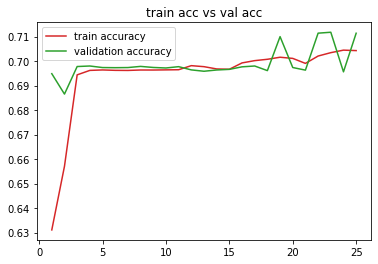

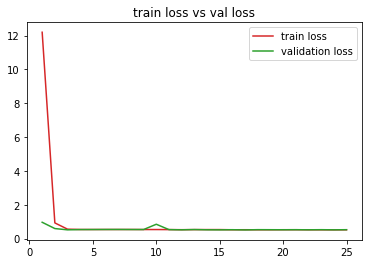

In [36]:
import matplotlib.pyplot as plt
plt.plot(epochs,train_acc,'tab:red',label='train accuracy')
plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,train_loss, 'tab:red', label ='train loss')
plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
model_D = load_model('deepLearning_model.keras')

In [37]:
# Make predictions on the test set
y_pred_test = (model_D.predict(X_test) > 0.5).astype(int)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)

# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)
print('\nClassification Report for the test set:')
print(class_report)

print('Accuracy for the test set:', accuracy_test)

Confusion Matrix for the test set:
[[18414 18423]
 [ 2777 34677]]

Classification Report for the test set:
              precision    recall  f1-score   support

         0.0       0.87      0.50      0.63     36837
         1.0       0.65      0.93      0.77     37454

    accuracy                           0.71     74291
   macro avg       0.76      0.71      0.70     74291
weighted avg       0.76      0.71      0.70     74291

Accuracy for the test set: 0.71463568938364


## Upload a Model

In [4]:
#import joblib
#model_filename = 'xgboost_SMOTE_model.pkl'
#loaded_model = joblib.load(model_filename)

## EXTRAS

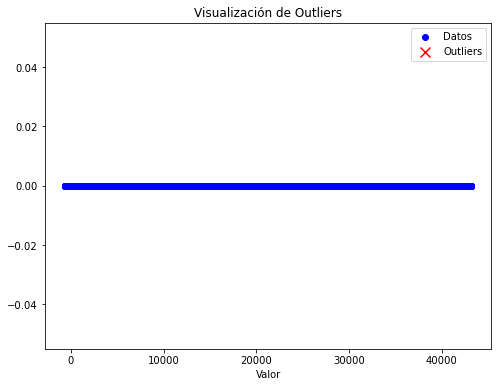

In [10]:
# -*- coding: utf-8 -*-
"""OUtliders.ipynb
 
Automatically generated by Colaboratory.
 
Original file is located at
https://colab.research.google.com/drive/18yXm_xykkesWAEsTx6pbUrcEGX3ccwEc
"""
 
#!pip instal dask
#pip install dask-ml#
 
#from google.colab import drive
#drive.mount('/content/drive')
 
import dask.dataframe as dd
import matplotlib.pyplot as plt
 
file_path  = "../../Data/EC_Data/*.csv"
 
# Lee el archivo CSV en un DataFrame Dask
#df = dd.read_csv(file_path)
df = dd.read_csv(file_path, header=0)
 
# Calcula el rango intercuartílico (IQR)
Q1 = df['col15_float'].quantile(0.25).compute()
Q3 = df['col15_float'].quantile(0.75).compute()
IQR = Q3 - Q1
 
# Calcula los límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
 
# Visualiza los outliers
outliers = df[(df['col15_float'] < lower_bound) | (df['col15_float'] > upper_bound)].compute()
 
# Grafica los datos y los outliers
plt.figure(figsize=(8, 6))
plt.scatter(df['col15_float'].compute(), [0] * len(df), label='Datos', color='blue')
plt.scatter(outliers['col15_float'], [0] * len(outliers), label='Outliers', color='red', marker='x', s=100)
plt.legend()
plt.xlabel('Valor')
plt.title('Visualización de Outliers')
plt.show()
 

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_boxplot(data, column_name):
    """
    Genera un boxplot de una columna de datos.

    Args:
        data (dask.dataframe.DataFrame): El DataFrame Dask que contiene los datos.
        column_name (str): El nombre de la columna que se va a graficar.

    Returns:
        None
    """
    # Crea el boxplot
    plt.figure(figsize=(8, 6))  # Ajusta el tamaño del gráfico
    sns.boxplot(x=data[column_name].compute())

    # Personaliza el gráfico
    plt.title(f'Boxplot de {column_name}')
    plt.xlabel(column_name)

    plt.show()

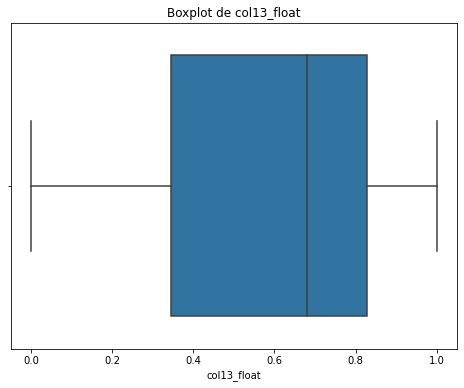

In [16]:
plot_boxplot(df, 'col13_float')